In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate


In [2]:
# Define the path to the file
file_path = 'C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/filtered_dataset_with_geo_info_with_encoding.parquet.gzip'

# Load the dataset
df = pd.read_parquet(file_path, engine='pyarrow')  # You can also use engine='fastparquet'
pd.set_option('display.max_columns', None)  # To show all columns


In [3]:
#work without county dummies
# Identify columns that start with "countyCode"
columns_to_drop = [column for column in df.columns if column.startswith('countyCode')]

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

#drop yearOfLoss
df = df.drop(columns = 'yearOfLoss')

In [4]:
##create separate dataframe of svd columns
# Create a list of the SVD column names
svd_columns = [f'svd_{i}' for i in range(1, 31)]

# Create a new DataFrame with only the SVD columns
svd_df = df[svd_columns].copy()

# Drop the SVD columns from the original DataFrame
df.drop(columns=svd_columns, inplace=True)

In [5]:
#Create baseline dataframes
Y = df['buildingrelativeDamage'].copy()
X = df.drop(columns='buildingrelativeDamage').copy()

In [6]:
# subset to 1000 observations to see if it runs correctly
svd_df = svd_df[0:5000]
Y = Y[0:5000]
X = X[0:5000]

In [7]:
#SVD selection
def svd_selection(X, svd_df, Y):
    # Dictionary to score mean accuracy results, keyed by column name
    scores = {}
    
    for col in svd_df.columns:
        # Concatenate the current SVD column with the original features
        XSvd = pd.concat([X, svd_df[[col]]], axis=1)
        
        # Initialize the regressor
        regr = RandomForestRegressor(criterion='absolute_error', max_depth = 40,  random_state=0)
        
        # Perform cross-validation
        cv_results = cross_validate(regr, XSvd, Y, cv=2, scoring='neg_mean_absolute_error')
        
        # Store the mean of the cross-validation results
        scores[col] = -np.mean(cv_results['test_score'])
        print('one more test')
        print(scores[col])
    
    # Find the column with the smallest mean test score
    best_col = min(scores, key=scores.get)
    
    # Return the name of the column with the smallest mean error
    return best_col, scores[best_col]

In [8]:

#keep track of scores and order of svd
svd_selection_cv_scores = np.zeros(30)
mae_scores = np.zeros(31)
orderSVD = []

#calculate baseline score
regr = RandomForestRegressor(criterion='absolute_error',  random_state=0)
cv_results = cross_validate(regr, X, Y, cv=5, scoring='neg_mean_absolute_error')
mae_scores[0] = -np.mean(cv_results['test_score'])

print('first done')
print(mae_scores[0])

#calculate mae score per svd variable
for i in range(1,31):
    #find which new column to include, and save test score on new column
    new_col, svd_selection_cv_scores[i-1] = svd_selection(X, svd_df, Y)
    
    #add selected svd column to X
    X = pd.concat([X, svd_df[[new_col]]], axis=1)
    
    #drop included svd column from svd dataframe    
    svd_df = svd_df.drop(columns = new_col)
    
    #keep track of order of svd variables by adding to list
    orderSVD.append(new_col)
    
    #run new cross validation and save mae 
    regr = RandomForestRegressor(criterion='absolute_error', random_state=0)
    cv_results = cross_validate(regr, X, Y, cv=5, scoring='neg_mean_absolute_error')
    mae_scores[i] = -np.mean(cv_results['test_score'])    
    print(i)
    print(new_col)
    print(mae_scores[i])

    
    
    
    

first done
0.18320488444723065
one more test
0.1828141262416846
one more test
0.18611245802860166
one more test
0.1874679592442131
one more test
0.18525328500041804
one more test
0.18731127347650384
one more test
0.18646960540886062
one more test
0.18591140389390537
one more test
0.1861873601092287
one more test
0.1850842187249701
one more test
0.18661336689593586
one more test
0.18699557935184177
one more test
0.1873242554529986
one more test
0.1877044511571096
one more test
0.18677922527916108
one more test
0.18769612905723526
one more test
0.1866637366386127
one more test
0.18785688567532044
one more test
0.1882363301195924
one more test
0.18761610050823277
one more test
0.18753055895847276
one more test
0.1880952127625687
one more test
0.1864597393660775
one more test
0.18718803681179058
one more test
0.18701691266775067
one more test
0.18667398709393207
one more test
0.18720473508367838
one more test
0.18712134262274394
one more test
0.1882532899277376
one more test
0.186779208821

one more test
0.18217008215662694
one more test
0.18249036433244264
one more test
0.18237922955888924
one more test
0.18256262178834087
one more test
0.1828940733431788
one more test
0.18273231925944242
one more test
0.1820095258912519
one more test
0.1826009255148654
one more test
0.1823121777747038
one more test
0.1823270279254839
one more test
0.18245578326708672
one more test
0.1824315375286448
one more test
0.18246382381112453
one more test
0.1826130163371027
one more test
0.18199510954654557
one more test
0.18282777578197557
one more test
0.18284617707028866
one more test
0.1830077245666258
one more test
0.1828880950997001
one more test
0.1830906511067729
10
svd_22
0.1768408639526084
one more test
0.18263127795796463
one more test
0.18241000910243227
one more test
0.18268135410230063
one more test
0.1825208887998574
one more test
0.18241064903559856
one more test
0.18259720279276853
one more test
0.18206512032807545
one more test
0.18262576432097177
one more test
0.18254154430916

KeyboardInterrupt: 

In [9]:
mae_scores

array([0.18320488, 0.17673518, 0.17727864, 0.17709145, 0.17652001,
       0.17707421, 0.17763274, 0.17781575, 0.17688519, 0.17706782,
       0.17684086, 0.17670172, 0.17713253, 0.17697391, 0.17717849,
       0.17686655, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [10]:
plt.plot(mae_scores[0:17])

NameError: name 'plt' is not defined

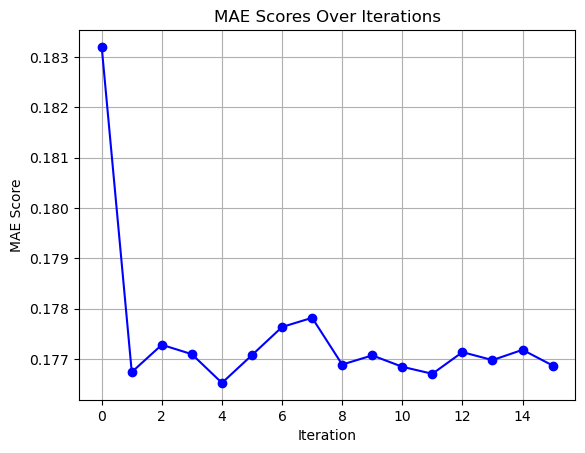

In [14]:
import matplotlib.pyplot as plt

# Assuming mae_scores is defined
# mae_scores = [your_data_here] # Make sure this line reflects your actual data

# Plotting the MAE scores
plt.plot(mae_scores[0:16], marker='o', linestyle='-', color='b') # 'o' markers, blue line
plt.title('MAE Scores Over Iterations') # Title of the plot
plt.xlabel('Iteration') # X-axis label
plt.ylabel('MAE Score') # Y-axis label
plt.grid(True) # Show grid lines for better readability
plt.show() # Display the plot


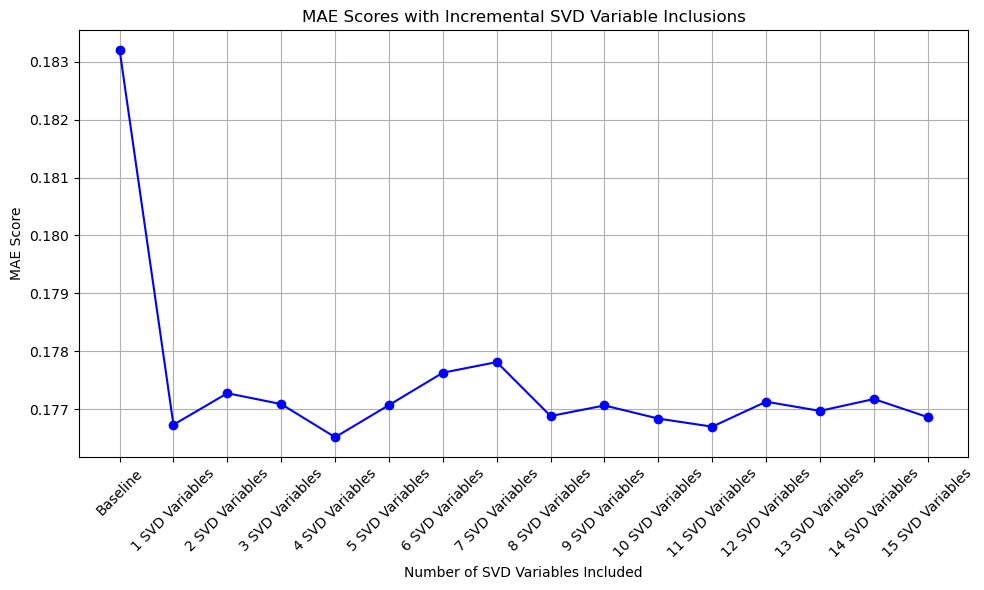

In [15]:
import matplotlib.pyplot as plt

# Assuming mae_scores is defined
# mae_scores = [your_data_here]  # Make sure this line reflects your actual data

# Define the number of observations to plot
num_observations = 16

# Generate custom x-axis labels
x_labels = ['Baseline'] + [f'{i+1} SVD Variables' for i in range(num_observations - 1)]

# Plotting the MAE scores for the first 16 observations
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size for better readability
plt.plot(mae_scores[0:num_observations], marker='o', linestyle='-', color='b')  # 'o' markers, blue line
plt.title('MAE Scores with Incremental SVD Variable Inclusions')  # Updated title
plt.xlabel('Number of SVD Variables Included')  # Updated x-axis label
plt.ylabel('MAE Score')  # Y-axis label
plt.xticks(range(num_observations), x_labels, rotation=45)  # Set custom x-axis tick labels with rotation for readability
plt.grid(True)  # Show grid lines for better readability
plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()  # Display the plot


In [16]:
orderSVD

['svd_1',
 'svd_23',
 'svd_6',
 'svd_25',
 'svd_16',
 'svd_14',
 'svd_24',
 'svd_8',
 'svd_12',
 'svd_22',
 'svd_10',
 'svd_17',
 'svd_4',
 'svd_3',
 'svd_19']